## Classification: Comparing Signature and TS2Vec

In [1]:
# packages
import torch
import pandas as pd
from pygsig.datasets.subduction import SubductionZone
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Download data

test_dataset = SubductionZone(poly_path='datasets/subduction/polygon.geojson',
                         rast_path='datasets/subduction/interface.grd',
                         label_path='datasets/subduction/nonlinear.json',
                         data_path='datasets/subduction/test.geojson',
                         site_path='datasets/subduction/location.geojson',
                         start_date=pd.Timestamp('2020-01-01 11:59:00+0000', tz='UTC'),
                         end_date=pd.Timestamp('2023-12-31 11:59:00+0000', tz='UTC'),
                         download=False)

100%|██████████| 86/86 [04:05<00:00,  2.85s/it]


In [8]:
train_dataset = SubductionZone(poly_path='datasets/subduction/polygon.geojson',
                         rast_path='datasets/subduction/interface.grd',
                         label_path='datasets/subduction/nonlinear.json',
                         data_path='datasets/subduction/train.geojson',
                         site_path='datasets/subduction/location.geojson',
                         start_date=pd.Timestamp('2008-01-01 11:59:00+0000', tz='UTC'),
                         end_date=pd.Timestamp('2019-12-31 11:59:00+0000', tz='UTC'),
                         download=False)

100%|██████████| 86/86 [07:10<00:00,  5.01s/it]


In [7]:
test_dataset.task = 'classification'
seq = test_dataset.get_graph(k=5)

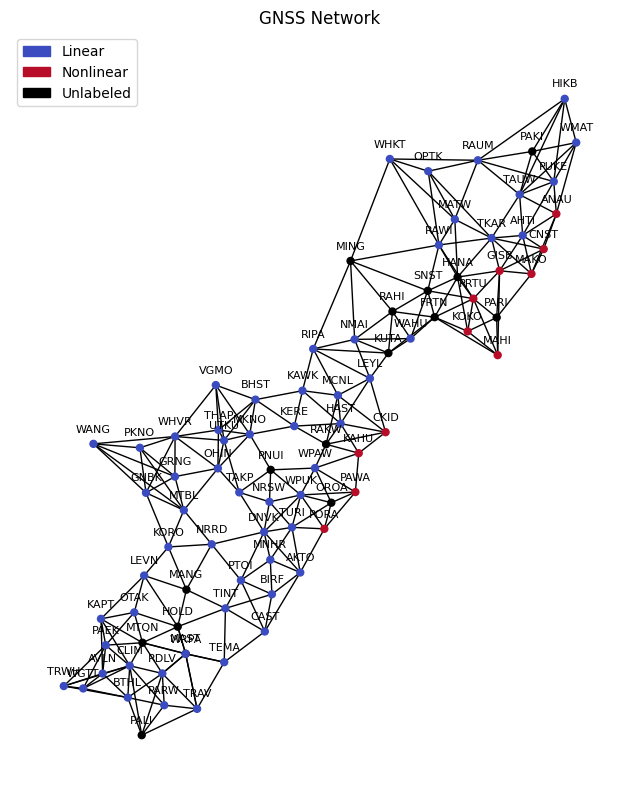

In [4]:
import matplotlib.pyplot as plt

blue = '#3b4cc0'
red = '#b70d28'

G = nx.Graph()
G.add_nodes_from(range(seq.num_nodes))
G.add_edges_from(seq[0].edge_index.T.tolist())

pos = {node: position.numpy() for node, position in enumerate(seq[0].pos)}
depth = {node: measurement.item() for node, measurement in enumerate(seq[0].y)}
vector_depth = np.array([depth[i] for i in range(len(depth))])

# Define color map based on labels
color_map = {0: blue, -1: 'black', 1: red}
node_colors = [color_map[depth[node]] for node in G.nodes]

plt.figure(figsize=(8, 10))
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors)
nx.draw_networkx_edges(G, pos=pos)
nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: dataset.siteIDs[i] for i in range(len(dataset.siteIDs))}, font_size=8)
plt.title('GNSS Network')
plt.axis('off')

# Create legend
import matplotlib.patches as mpatches
linear_patch = mpatches.Patch(color=blue, label='Linear')
nonlinear_patch = mpatches.Patch(color=red, label='Nonlinear')
unlabeled_patch = mpatches.Patch(color='black', label='Unlabeled')
plt.legend(handles=[linear_patch, nonlinear_patch, unlabeled_patch])
plt.show()


GNN with TS2Vec features trained on training data in each split seperately

Model: GCNClassification
Number of parameters: 20801
Split 1/4


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Split 2/4


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Split 3/4


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Split 4/4


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

Accuracy: 0.9195 ± 0.0550, F1: 0.5422 ± 0.3340, Precision: 0.6167 ± 0.3753, Recall: 0.5292 ± 0.3664


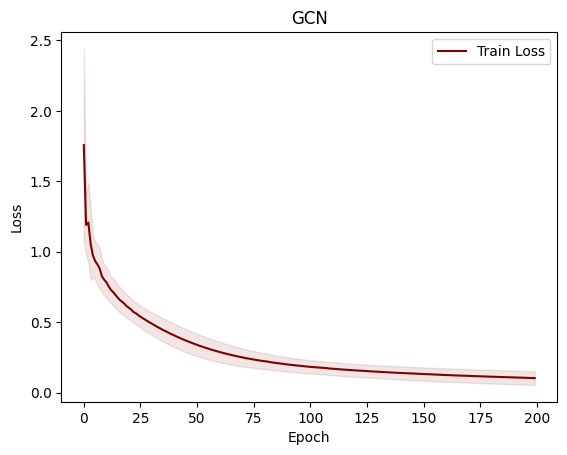

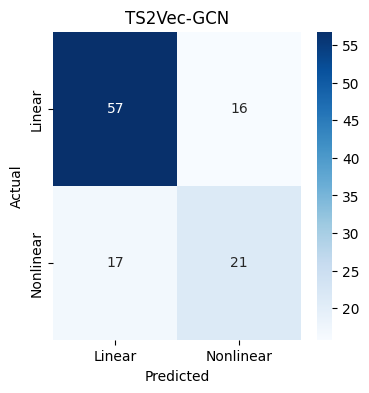

In [5]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
from ts2vec.ts2vec import TS2Vec
import signatory


# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = signatory.signature_channels(2*seq.num_node_features,3)
num_hidden = 64

print_during_training = False
retrain_encoder = False

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        if retrain_encoder:
            # train encoder on the training data
            X_train = test_dataset.X[train_mask]
            encoder = TS2Vec(input_dims=3,device='cpu', hidden_dims=64, output_dims=in_channels,batch_size=1)
            loss_log = encoder.fit(X_train,verbose=True)
            torch.save(encoder,f'encoders/geonet/splits/TS2Vec_{split}.pt')
        else:
            # load encoder if already trained
            encoder = torch.load(f'encoders/geonet/splits/TS2Vec_{split}.pt')
        
        # Apply signature transformation to the sequential data to obtain static graph
        ts2vec = TS2VecFeatures(encoder,normalize=False)
        data = ts2vec(seq)

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=0).mean(axis=0)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

GNN with TS2Vec features trained on training data temporally nonoverlapping

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
from ts2vec.ts2vec import TS2Vec
import signatory


# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = signatory.signature_channels(2*seq.num_node_features,3)
num_hidden = 64

print_during_training = False
retrain_encoder = True

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

if retrain_encoder:
    X_train = train_dataset.X
    encoder = TS2Vec(input_dims=3,device='cpu', hidden_dims=64, output_dims=in_channels,batch_size=1)
    loss_log = encoder.fit(X_train,verbose=True)
    torch.save(encoder,f'encoders/geonet/train/TS2Vec.pt')
else:
    encoder = torch.load(f'encoders/geonet/train/TS2Vec.pt')

# Apply signature transformation to the sequential data to obtain static graph
ts2vec = TS2VecFeatures(encoder,normalize=False)
data = ts2vec(seq)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=0).mean(axis=0)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Epoch #0: loss=3272.879793921182
Epoch #1: loss=216.15673961195836
Epoch #2: loss=108.18236903257149
Epoch #3: loss=70.50761435752692


### Path signature encoder

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
from ts2vec.ts2vec import TS2Vec
import signatory


# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = signatory.signature_channels(2*seq.num_node_features,3)
num_hidden = 64

print_during_training = False
retrain_encoder = True

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Apply signature transformation to the sequential data to obtain static graph
sig2vec = SignatureFeatures(sig_depth=3,lead_lag=True,normalize=False)
data = sig2vec(seq)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=0).mean(axis=0)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Summary figure

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First plot: Mean Prediction
G = nx.Graph()
G.add_nodes_from(range(seq.num_nodes))
G.add_edges_from(seq[0].edge_index.T.tolist())

pos = {node: position.numpy() for node, position in enumerate(seq[0].pos)}
depth = {node: measurement.item() for node, measurement in enumerate(seq[0].y)}
vector_depth = np.array([depth[i] for i in range(len(depth))])

# Define color map based on mean predictions
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(ts2vec_mean_prediction[node]) for node in G.nodes]

axes[1].set_title('Predicted Labels (TS2Vec-GCN)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[1])
nx.draw_networkx_edges(G, pos=pos, ax=axes[1], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=8, ax=axes[1])
axes[1].axis('off')

# Define color map based on mean predictions
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(sig_mean_prediction[node]) for node in G.nodes]

axes[2].set_title('Predicted Labels (Signature-GCN)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[2])
nx.draw_networkx_edges(G, pos=pos, ax=axes[2], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=8, ax=axes[1])
axes[2].axis('off')

# Create color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
# fig.colorbar(sm, label='Nonlinearity', ax=axes[2])

# Second plot: Labels
# Define color map based on labels
color_map = {0: cmap(0), -1: 'black', 1: cmap(0.99)}
node_colors = [color_map[depth[node]] for node in G.nodes]

axes[0].set_title('Ground Truth (Truttmann et al., 2024)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[0])
nx.draw_networkx_edges(G, pos=pos, ax=axes[0], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=6, ax=axes[0])
axes[0].axis('off')

# Create legend
linear_patch = mpatches.Patch(color=cmap(0), label='Linear')
nonlinear_patch = mpatches.Patch(color=cmap(0.99), label='Nonlinear')
unlabeled_patch = mpatches.Patch(color='black', label='Data Gaps')
axes[0].legend(handles=[linear_patch, nonlinear_patch, unlabeled_patch])

# Adjust space between figures
plt.subplots_adjust(wspace=0.3)

# Title
plt.show()


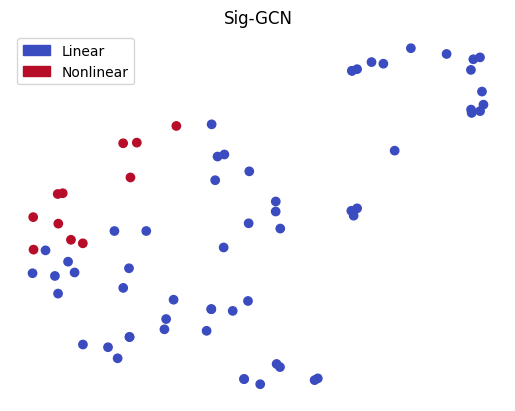

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sig_latent_variables = model.conv[0](data.x, data.edge_index)

tsne = TSNE(n_components=2, perplexity=10, random_state=31)
X_embedded = tsne.fit_transform(ts2vec_latent_variables.detach().numpy())

label_mask = data.y != -1

# Define color map based on labels
color_map = {0: blue, 1: red}
node_colors = [color_map[label.item()] for label in data.y[label_mask]]

plt.figure()
scatter = plt.scatter(X_embedded[label_mask, 0], X_embedded[label_mask, 1], c=node_colors)

# Add labels to the scatter plot
for i, txt in enumerate(np.array(dataset.siteIDs)[label_mask]):
    plt.annotate(txt, (X_embedded[label_mask, 0][i], X_embedded[label_mask, 1][i]), fontsize=6)

plt.legend(handles=[mpatches.Patch(color=blue, label='Linear'), mpatches.Patch(color=red, label='Nonlinear')])
plt.title('TS2Vec-GCN')
plt.axis('off')
plt.show()

## Regression: Comparing Signature and TS2Vec

In [40]:
# packages
import torch
import pandas as pd
from pygsig.datasets.subduction import SubductionZone
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from ts2vec import ts2vec

In [30]:
from torch_geometric_temporal.signal.train_test_split import temporal_signal_split

dataset.task = "regression"
seq = dataset.get_graph(k=4)
encoder_seq, gnn_seq = temporal_signal_split(seq,train_ratio=0.25)

Model: GCNRegression
Number of parameters: 33153


100%|██████████| 100/100 [00:31<00:00,  3.19it/s]

RMSE: 0.9199 ± 0.2079, MAE: 0.6336 ± 0.1003


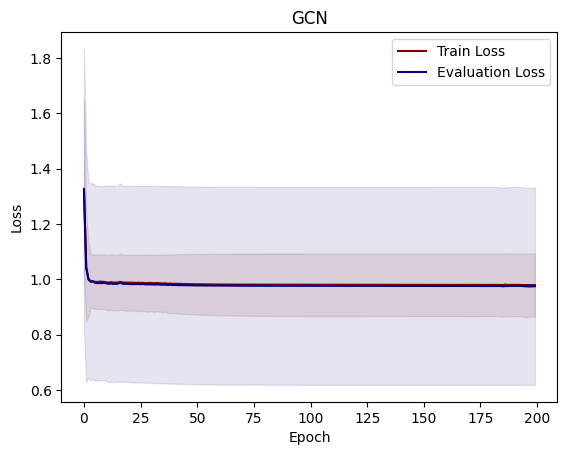

In [83]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler

# Import custom modules
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification,GCNRegression
from pygsig.graph import split_nodes
from pygsig.signature import SignatureFeatures

# encoder
encoder = torch.load('encoders/geonet/TS2Vec.pt')
ts2vec = TS2VecFeatures(encoder,normalize=False)

# Apply signature transformation to the sequential data
data = ts2vec(gnn_seq)

# Normalize the target values
scaler = StandardScaler()
scaler.fit(data.y.reshape(-1,1))
data.y = torch.tensor(scaler.transform(data.y.reshape(-1,1))).squeeze().float()

# Set up parameters
num_nodes = data.num_nodes
num_splits = 5
num_trials = 20
num_epochs = 200
learning_rate = 1e-3
lasso = 0
num_hidden = data.num_node_features
print_during_training = False


# Initialize models
models = []
models.append(GCNRegression(num_channels=[data.num_node_features, num_hidden, num_hidden, 1]))

model_names = ['GCN']

rmse_models = []
predictions_models = []

# Create a mask for valid labels (ignoring -1)
label_mask = data.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.MSELoss()

# Initialize arrays for metrics
rmse_models = []
confusion_models = []
all_predictions = []

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lasso)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    rmse = np.zeros([num_splits, num_trials])
    mae = np.zeros([num_splits, num_trials])
    
    with tqdm(total=num_splits * num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits, test_ratio=1.0, seed=31) # no validation
        
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            
            # Create masks for training, evaluation, and testing
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            
            # Apply label mask to exclude -1 values
            valid_train_mask = train_mask & label_mask
            valid_eval_mask = eval_mask & label_mask
            valid_test_mask = test_mask & label_mask

            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index, data.edge_attr)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        eval_loss = criterion(out[valid_eval_mask], seq.y[valid_eval_mask].unsqueeze(1))
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                        eval_losses[split, trial, epoch] = test_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Eval Loss: {eval_loss.item():.4f}')
                
                pbar.update(1)

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)

                    # Compute performance metrics
                    rmse[split, trial] = np.sqrt(mean_squared_error(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy()))
                    mae[split, trial] = mean_absolute_error(y_true[valid_test_mask].numpy(), predictions[valid_test_mask].numpy())
                    all_predictions.append(out)

                    

    # Print results for the model
    print(f'RMSE: {np.mean(rmse):.4f} ± {np.std(rmse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f}')

    rmse_models.append(rmse)

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    avg_eval_losses = np.mean(eval_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
    std_eval_losses = np.std(eval_losses, axis=(0, 1))
    
    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses, label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1, color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()